<div class="alert alert-info" role="alert">
  <hr> <center> <font size="+3.5"> <b> Comparaison de différents embedding des données d'entrée dans le but de réduire l'erreur de reconstruction
 </b> </font> </center> <hr>
</div>

<div class="alert alert-block" role="alert">
    <center><b> <u>Auteur :</u>  Clement GOUBET  </b></center>
</div>
<div class="alert alert-block" role="alert">
    <center> <font size="+1.5"> <b>  23 juillet 2019  </b>  </font> </center>
</div>

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 0. Preparation de l'environnement de travail </b> </font> <hr>
</div>

# Chargement des modules et mise en forme des données

In [174]:
#import external libraries
import sys
import os
import datetime
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
import seaborn as sn
from scipy import stats
import cv2 #from open-cv, to convert array to images
from IPython.display import Image
from tensorflow.keras.callbacks import TensorBoard
from time import time
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [175]:
#root git folder 
name_model="influence_t2v"
path_second_folder = %pwd #"/home/goubetcle/Documents/Git/VAE/"
save_path = os.path.join(path_second_folder,"Results")#"/home/goubetcle/Documents/VAE/"
log_dir_model=os.path.join(save_path,"logs")
#path_main_folder = '/home/jovyan'#specify the root folder of the git repo

#add  to path root git folder 
sys.path.append(path_second_folder)

In [176]:
import importlib

sys.path.append(path_second_folder+'/src')

#import models, loss_class, params_class,AE_blocks,metrics
from src.models import *
#importlib.reload(models)
from src.loss_class import *
#importlib.reload(loss_class)
from src.params_class import *
#importlib.reload(params_class)
import src.AE_blocks
#importlib.reload(AE_blocks)
from src.metrics import *
#importlib.reload(metrics)
from src.utils import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Les données de consommation et de température sont des prises de mesure par pas de temps 30 minutes pendant 5 années de décembre 2012 à décembre 2020. 

In [177]:
# Load dataframe
dataset_csv = os.path.join('data', "dataset_2012_2020.csv")
df_data = pd.read_csv(dataset_csv, sep=";",)
df_data.utc_datetime = pd.to_datetime(df_data.utc_datetime, utc=True)

#Visualize data frame head
df_data.tail(5)

utc_datetime  Consommation  prevision_j  prevision_j-1  \
157819 2020-12-31 21:30:00+00:00       64423.0      63700.0        64400.0   
157820 2020-12-31 22:00:00+00:00       63505.0      63200.0        63800.0   
157821 2020-12-31 22:30:00+00:00       64331.0      65200.0        65800.0   
157822 2020-12-31 23:00:00+00:00       66853.0      67000.0        67500.0   
157823 2020-12-31 23:30:00+00:00       66750.0      67200.0        67600.0   

        prevision_neb  prevision_temp  is_holidays  
157819       3.400764        2.328079          0.0  
157820       3.479000        2.164250          0.0  
157821       3.490986        2.029558          0.0  
157822       3.369000        1.950550          0.0  
157823       3.045322        1.953771          0.0

On s'intéresse ici à caractériser les profils journaliers. L'ensemble de données est donc transformé pour que notre jeu d'entrée soit ait en colonnes les points de mesure journaliers de la consommation d'électricité. Avant cela, tout ce qui va être inséré comme entrées du modèle est ici normalisé sur l'ensemble des mesures, puis mis en profils journaliers.

Notre jeu d'entrainement et pour référence est le jeu de données 2012-2018.

In [186]:
ds = pd.DataFrame({"days" : df_data.utc_datetime.dt.date, "minute":df_data.utc_datetime.dt.minute+60*df_data.utc_datetime.dt.hour})

df_conso, df_temp, df_prevision = make_chronics(df=pd.concat([df_data, ds], axis=1),
                                               toshape_columns=["Consommation", "prevision_temp", "prevision_j-1"],
                                               pivot_indexcol="days", pivot_columncol="minute")

df_conso.head()

minute         0        30       60       90       120      150      180   \
days                                                                        
2012-01-01  58315.0  58315.0  56231.0  56075.0  55532.0  54911.0  52496.0   
2012-01-02  55164.0  53643.0  51404.0  50842.0  50399.0  50113.0  48201.0   
2012-01-03  64600.0  63033.0  60533.0  60426.0  60104.0  59861.0  57915.0   
2012-01-04  65081.0  63129.0  60564.0  60194.0  59709.0  59353.0  57569.0   
2012-01-05  67042.0  65123.0  62447.0  62331.0  61889.0  61501.0  59574.0   

minute         210      240      270   ...     1140     1170     1200  \
days                                   ...                              
2012-01-01  50664.0  49161.0  47596.0  ...  57333.0  57786.0  57752.0   
2012-01-02  47182.0  46306.0  46294.0  ...  73263.0  72615.0  71079.0   
2012-01-03  56691.0  55743.0  55656.0  ...  76698.0  75660.0  73535.0   
2012-01-04  56545.0  55655.0  55628.0  ...  78337.0  77173.0  75281.0   
2012-01-05  58245.0  57258.0  56923.0  ...  78351.0  76928.0  74868.0   

minute         1230     1260     1290     1320     1350     1380     1410  
days                                                                       
2012-01-01  56946.0  56054.0  54975.0  53890.0  54348.0  56577.0  55634.0  
2012-01-02  69050.0  67435.0  65332.0  63756.0  64030.0  65929.0  64902.0  
2012-01-03  71275.0  69189.0  66829.0  64861.0  64898.0  66939.0  65479.0  
2012-01-04  72985.0  70927.0  68726.0  66808.0  66878.0  68550.0  67376.0  
2012-01-05  72432.0  70197.0  68036.0  66269.0  66070.0  68169.0  66910.0  

[5 rows x 48 columns]

In [187]:
df_conso, conso_scaler = apply_scaler(df_data, column="Consommation", df_chronic=df_conso,
                                      reference_window=df_data.utc_datetime.dt.year <=2018)
df_conso.head()

minute          0         30        60        90        120       150   \
days                                                                     
2012-01-01  0.306926  0.306926  0.135886  0.123082  0.078516  0.027549   
2012-01-02  0.048313 -0.076520 -0.260282 -0.306408 -0.342766 -0.366239   
2012-01-03  0.822757  0.694148  0.488965  0.480183  0.453756  0.433812   
2012-01-04  0.862234  0.702027  0.491509  0.461142  0.421337  0.392118   
2012-01-05  1.023180  0.865682  0.646053  0.636533  0.600256  0.568412   

minute          180       210       240       270   ...      1140      1170  \
days                                                ...                       
2012-01-01 -0.170658 -0.321017 -0.444373 -0.572818  ...  0.226330  0.263510   
2012-01-02 -0.523163 -0.606796 -0.678692 -0.679677  ...  1.533758  1.480575   
2012-01-03  0.274097  0.173639  0.095834  0.088693  ...  1.815680  1.730488   
2012-01-04  0.245700  0.161657  0.088611  0.086395  ...  1.950198  1.854665   
2012-01-05  0.410257  0.301181  0.220175  0.192680  ...  1.951348  1.834557   

minute          1200      1230      1260      1290      1320      1350  \
days                                                                     
2012-01-01  0.260719  0.194568  0.121359  0.032801 -0.056248 -0.018659   
2012-01-02  1.354510  1.187984  1.055435  0.882835  0.753487  0.775975   
2012-01-03  1.556082  1.370597  1.199392  1.005699  0.844178  0.847215   
2012-01-04  1.699382  1.510942  1.342035  1.161392  1.003975  1.009720   
2012-01-05  1.665486  1.465555  1.282122  1.104761  0.959738  0.943405   

minute          1380      1410  
days                            
2012-01-01  0.164283  0.086888  
2012-01-02  0.931833  0.847543  
2012-01-03  1.014727  0.894900  
2012-01-04  1.146947  1.050593  
2012-01-05  1.115677  1.012347  

[5 rows x 48 columns]

'df_conso' est constitué des profils journaliers de consommation d'lélectricité que l'on va mettre en entrée de notre VAE

Pour interpréter notre représentation, on peut chercher à visualiser des paramètres connus associés à nos profils journaliers. Ici il s'agit notamment de données calendaires (mois, weekend, jour férié), auxquels on peut rajouter la température moyenne observée sur la journée (par exemple), ou encore la pente moyenne du profil.

Ces informations sont à passer dans calendar_info pour être visualisés dans une projection Tensorboard, et à passer en type et en valeur respectivement dans le dictionnaire factorDesc et factorMatrix pour servir dans l'évaluation des latents. 

In [188]:
#importation des données calendaires
df_calendar = make_df_calendar(pd.DataFrame({"ds" : pd.to_datetime(np.asarray(df_conso.index))}))

df_holidays = pd.concat([df_data[["is_holidays"]],pd.DataFrame({"ds" : pd.to_datetime(ds.days.values)})], axis=1).drop_duplicates(
                                               subset="ds").reset_index(drop= True)

df_calendar = df_calendar.merge(df_holidays, on="ds", how="left").rename(columns={"is_holidays":"is_holiday_day"})

df_calendar.head(5)

ds  month  weekday  is_weekend  year  is_holiday_day
0 2012-01-01      1        6           1  2012             1.0
1 2012-01-02      1        0           0  2012             0.0
2 2012-01-03      1        1           0  2012             0.0
3 2012-01-04      1        2           0  2012             0.0
4 2012-01-05      1        3           0  2012             0.0

In [189]:
#explicit the potential bridge days taken as extended holidays
day_hol = df_calendar[['weekday', 'is_holiday_day']].copy().values
bridge_index=[]
for i in range(day_hol.shape[0]):
    if day_hol[i,1]==1:
        if day_hol[i,0]==1:
            bridge_index.append(i-1)
        elif day_hol[i,0]==3:
            bridge_index.append(i+1)

bridges = np.zeros(day_hol.shape[0])
bridges[np.asarray(bridge_index)] = 1

df_calendar['potential_bridge_holiday'] = bridges
#calendar_info['potential_bridge_holiday'].describe()

In [190]:
calendar_factors = ["weekday", "is_weekend", "month", "is_holiday_day"]
factors = df_calendar[calendar_factors].copy()
factorDesc = {ff : 'category' for ff in calendar_factors}

temperatureMean= df_temp.mean(axis=1).values.reshape(-1,1)
factorMatrix = np.c_[factors.values,temperatureMean]
factorDesc['temperature']='regressor'


# Tools to evaluate the representations

In [191]:
from math import cos, sin
#visualisation d'une représentation 2D dans le notebook
def prez_2D(x_encoded, factorMatrix, temperatureMean):
    proj2D = PCA(2)
    proj = proj2D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=500, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,0]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index].ravel(), marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');
    plt.show()
    
def prez_3D(x_encoded, factorMatrix, temperatureMean):
    proj3D = PCA(3)
    proj_z = proj3D.fit_transform(x_encoded)
    plt.figure(figsize=(36,18))
    
    proj = proj_z[:,:2]
    third = proj_z[:,2]
    
    proj = proj + np.tile(third.reshape(-1,1), (1,2)) * np.tile(np.array([[-cos(0.785),sin(0.785)]]),(nPoints,1))
    
    size = 300  + (1.- np.exp(-third / max(third))) * 800
    #visualisation des mois par un disque de fond coloré
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= factorMatrix[index,2], marker = 'o', s=size, alpha=0.5, cmap = 'Paired')

    plt.colorbar().set_label('month');
    
    #visualisation de la température par la coloration graduelle du jour de la semaine
    for i in np.unique(factorMatrix[:,1]):
        i = int(i)
        index = factorMatrix[:,0]==i
        plt.scatter(x=proj[index,0], y=proj[index,1], c= temperatureMean[index], marker = '$'+str(i)+'$', s=200)

    plt.colorbar().set_label('temperature');

Pour créer une représentation sous tensorboard, la fonction suivante regroupe toutes les étapes. Le booléen includeConsuptionProfileImages active ou non le marqueur des points à l'image des profils de consommation.

In [192]:
def tensorboardProjection(name_model,x, x_hat, x_encoded, x_conso, calendar_info, log_dir_projector, includeConsumptionProfileImages=True):
    #can take a bit longer to create and load in tensorboard projector, but it looks better in the projector
    if includeConsumptionProfileImages:
        nPoints=1500 #if you want to visualize images of consumption profiles and its recontruction in tensorboard, there is a maximum size that can be handle for a sprite image. 1830 is  
        x_encoded_reduced=x_encoded[0:nPoints,]
        images=createLoadProfileImages(x,x_hat,nPoints)
    else:
        nPoints=df_conso.shape[0]
        
    if includeConsumptionProfileImages:
        sprites=images_to_sprite(images)
        cv2.imwrite(os.path.join(log_dir_projector, 'sprite_4_classes.png'), sprites)
    
    writeMetaData(log_dir_projector,x_conso,calendar_info,nPoints,has_Odd=False)
    if includeConsumptionProfileImages:
        buildProjector(x_encoded_reduced,images=images, log_dir=log_dir_projector)
    else:
        buildProjector(x_encoded,images=None, log_dir=log_dir_projector)
        
    print(log_dir_projector)

In [193]:
#Visualisation des courbes de charge en entrée et reconstruite par le modèle

def display_loads(x, x_hat,date,mae):
    fig = plt.figure(dpi=100,figsize=(5,5))
    #set(gca,'Color','k')
    plt.plot(scaler_conso.inverse_transform(x), label = 'truth')
    plt.plot(scaler_conso.inverse_transform(x_hat), '--', label = 'reconstruction')
    plt.title(date+' - mean absolute error %0.2f GW' %(mae*std_sc/1000))
    plt.xlabel('hours')
    plt.ylabel('load (MW)')
    plt.xlim((0,48))
    plt.xticks([5,11,17,23,29,35,41], [3,6,9,12,15,18,21])
    plt.legend(loc='lower right')
    plt.grid();

<div class="alert alert-info" role="alert">
    <font size="+2"> <b> 1. Un modèle classique </b> </font> <hr>
</div>

## Rappels

Les autoencodeurs variationnels sont des modèles qui fonctionnent en duo:
- un encodeur qui traduit les données d'entrée dans un espace latent de dimension arbitrairement choisie. Plus exactement il cherche les paramètres de distribution des variables latentes dans chacune des dimensions.
- un decodeur qui cherche à reconstruire les entrées à partir des coordonnées dans l'espace latent

Pendant l'appentissage, le lien entre encodeur et decodeur est réalisé par l'échantillage selon les paramètres de distribution appris : chaque échantillon a des coordonnées latentes tirées aléatoirement selon cette dernière, que le décodeur cherche à retraduire dans l'espace de dimension initial. 

## Construire et entrainer un modèle VAE ou CVAE

Il s'agit dans un premier temps de paramétrer les dimensions des couches de nos réseaux de neurone:
- celles de l'encodeur e_dim
- celles du décodeur d_dims
- les dimensions de notre espace latent z_dim (chaque paramètre de distribution sera donc aussi de dimension z_dim)
- les dimensions de notre embedding des conditions dans le cas dans CVAE

In [194]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[12,10,8,6]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[6,8,10,12]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = 12

Pour les paramètres liés au modèle, il faut rappeler le fonctionnement du VAE. On cherche la maximisation de la borne inférieure de la log-vraissemblance du modèle reconstruit ou ELBO qui se décompose en deux termes :

ELBO $= \mathbb{E}_{q_\phi(z|x)} \log(p_\theta(x|z)) - KL(q_\phi(z|x) \| p(z))$

Dans notre objectif d'apprentissage, cela est traduit par une perte à minimiser de la forme:

Obj $= \|x - \hat{x}\| +  KL(q_\phi(z|x) \| p(z))$.

- L'erreur de reconstruction peut être choisie selon une mesure en norme L1 ou L2. La norme L1 permet notamment d'obtenir des profils avec moins de valeurs abérrantes.

- Un prior $p(z)$ laplacien plutôt que gaussien permet des concentrations plus piquées des groupements similaires, et renvoie plus loin les points atypiques. 


- Par ailleurs, pour faciliter l'apprentissage du modèle de façon structurée dans les dimensions choisies de l'espace latent, l'action peut se porter sur le choix du prior comme sur des critères de régularisation devant le terme de divergence.

    Ces termes de régularisation s'appliquent de la façon suivante :

    Obj $= \|x - \hat{x}\| +  \beta KL(q_\phi(z|x) \| p(z)) + \gamma MMD(q_\phi(z) \| p(z))$ si modèle InfoVAE
    avec $\beta \in \left[0,1\right] $ et $\gamma \ge 0$ (si possible grand)

In [195]:
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16

On va mettre en forme ici les facteurs sur lesquels on va rendre la représentation latente agnostique. Attention à normaliser les variables quantitatives et à one-hot encoder les variables catégorielles. 

In [196]:
#on va conditionner sur les profils de température et le mois
calendar_cond = []
condtovae_dims = []
condarray=[]

df_temp, _ = apply_scaler(df_data, column="prevision_temp", df_chronic=df_temp,
                                      reference_window=None)

condarray.append(df_temp.values)
condtovae_dims.append(condarray[-1].shape[1])

for cc in calendar_cond:
    condarray.append(pd.get_dummies(df_calendar[cc], prefix=cc).values)
    condtovae_dims.append(condarray[-1].shape[1])



In [197]:
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)

In [198]:
vae_params.set_model_params()
vae_params.set_training_params()

Default values for model architecture are:
with_embedding  :=  False
with_Time2Vec  :=  True
emb_dims  :=  []
kernel_initializer  :=  glorot_uniform
bias_initializer  :=  glorot_uniform
reparametrize  :=  GaussianSampling
intel_function  :=  scalar_binary
input_dims  :=  48
output_dims  :=  48
t2v_dims  :=  12
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [12, 10, 8, 6]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [6, 12, 24, 48]
latent_encoder_dims  :=  [4, 3, 3, 4]
latent_mask  :=  0
decoder_type  :=  InceptionBlock_model
embedding_type  :=  EmbeddingBlock_model
cond_dims  :=  []
cond_insert  :=  {'encoder': [], 'decoder': []}
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003


In [199]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.input_dims = input_dim
vae_params.model_params.output_dims = input_dim
vae_params.model_params.cond_dims = []
vae_params.model_params.with_embedding = False
vae_params.model_params.with_Time2Vec = False
vae_params.model_params.emb_dims = [[48,8],[12,8],6]
vae_params.model_params.nb_encoder_ensemble = 1

## Calibrage du KernelPCA pour embedding de données


In [200]:
train_set = df_calendar.year.values <= 2018
test_set = df_calendar.year.values == 2019

input_cvae = df_conso.values[train_set,:]
output_cvae = df_conso.values[train_set,:]
test_input_cvae = df_conso.values[test_set,:]
test_output_cvae = df_conso.values[test_set,:]

### Calcul de la variance expliquée par les axes d'une ACP de dimension 48.

Text(0.5, 1.0, '2')

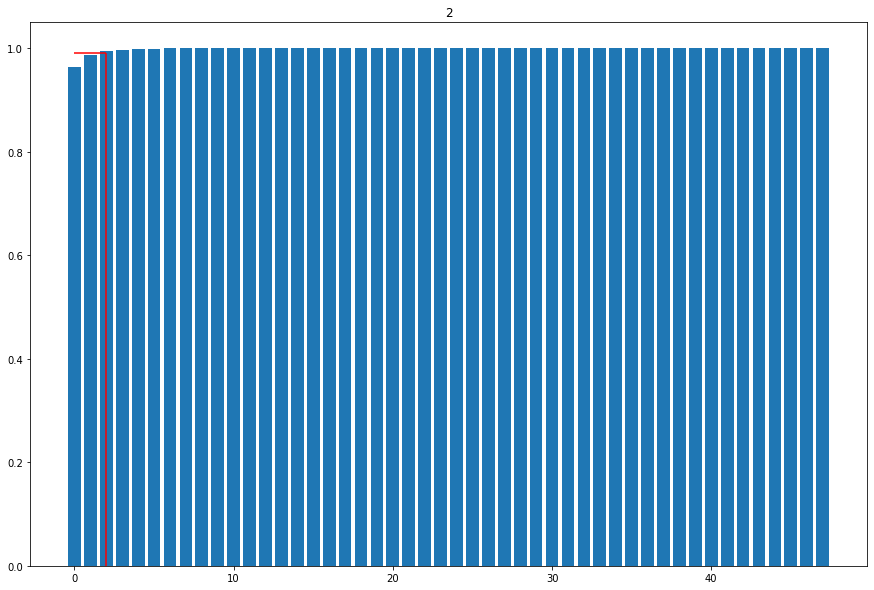

In [205]:
from sklearn.decomposition import KernelPCA
n_dims = input_cvae.shape[1]
model = PCA(n_components=n_dims)
model.fit(input_cvae)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.99)

plt.figure(figsize=(15,10))
plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.99, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.99, colors='r')
plt.title(str(meilleur_dims))

### Recherche des hyperparamètres de l'ACP à noyaux donnant la meilleure MAE de reconstruction. 

In [238]:
pca_dims = np.arange(4,36)
cv=5
kernels = ['linear','poly','rbf']
mae_kpca_error = {i: {k: [] for k in kernels} for i in range(cv)} 
for i in range(cv):
    for dim in pca_dims:
        for k in kernels: 
            kpca = KernelPCA(n_components=dim, fit_inverse_transform=True,kernel=k)
            kpca.fit(input_cvae)
            z_kpca = kpca.transform(test_input_cvae)
            x_hat_kpca = kpca.inverse_transform(z_kpca)
            mae_kpca_error[i][k].append(np.mean(np.abs(conso_scaler.inverse_transform(x_hat_kpca).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019])))

In [239]:
mae_kpca_per_model = {k: np.mean([mae_kpca_error[i][k] for i in range(cv)], axis=0) for k in kernels}

In [240]:
mae_kpca_per_model

{'linear': array([3478.76933435, 3463.20295038, 3454.88082764, 3464.5266922 ,
        3473.6929094 , 3469.68765055, 3467.92751336, 3468.43559836,
        3468.46354532, 3467.09942941, 3468.48379908, 3466.86727857,
        3463.51157119, 3463.70017297, 3465.01970589, 3464.61089507,
        3464.90668627, 3466.14218942, 3466.19406117, 3466.81110502,
        3466.75093628, 3466.55929233, 3466.53593317, 3466.36436394,
        3466.3553776 , 3466.32099301, 3466.27307648, 3466.33663498,
        3466.28984338, 3466.27480346, 3466.26267754, 3466.21944454]),
 'poly': array([883.28486215, 767.45211951, 570.08135145, 462.46776107,
        460.44301947, 400.90373829, 386.5412683 , 346.93541186,
        345.80730824, 323.00202415, 320.58642577, 308.4978234 ,
        299.19582279, 298.75337975, 294.14217299, 296.0617039 ,
        298.14047272, 298.44731416, 301.0460422 , 304.78285938,
        308.51486808, 311.87538604, 316.26417741, 320.21707037,
        324.04401465, 327.41648645, 331.34728084, 33

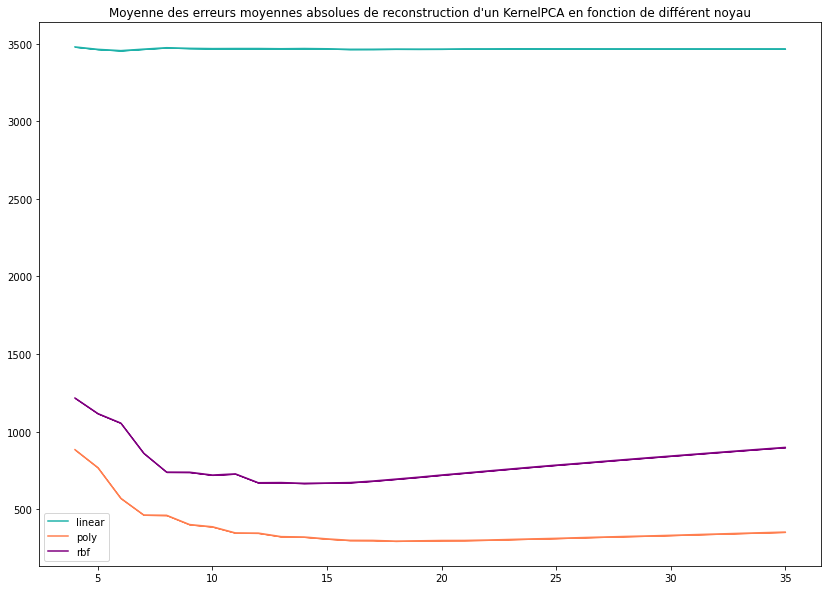

In [241]:
plt.figure(figsize=(14,10))
colors = ["lightseagreen", "coral", "purple"]
for idk, k in enumerate(kernels):
    plt.plot(pca_dims, mae_kpca_per_model[k], label=k, color=colors[idk])
    ci = 1.96 * np.std([mae_kpca_error[i][k] for i in range(cv)], axis=0)/np.sqrt(len(pca_dims))
    plt.fill_between(pca_dims, (mae_kpca_per_model[k] - ci), (mae_kpca_per_model[k] - ci), color=colors[idk])
plt.legend()
plt.title("Moyenne des erreurs moyennes absolues de reconstruction d'un KernelPCA en fonction de différent noyau")
plt.show()

In [242]:
pca_dims = np.arange(4,36)
cv=5
degrees = np.arange(1,5)
mae_kpca_poly_error = {i: {d: [] for d in degrees} for i in range(cv)} 
for i in range(cv):
    for dim in pca_dims:
        for d in degrees: 
            kpca = KernelPCA(n_components=dim, fit_inverse_transform=True,kernel='poly', degree=d)
            kpca.fit(input_cvae)
            z_kpca = kpca.transform(test_input_cvae)
            x_hat_kpca = kpca.inverse_transform(z_kpca)
            mae_kpca_poly_error[i][d].append(np.mean(np.abs(conso_scaler.inverse_transform(x_hat_kpca).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019])))

In [256]:
mae_kpca_per_degree = {d: np.mean([mae_kpca_poly_error[i][d] for i in range(cv)], axis=0) for d in degrees}

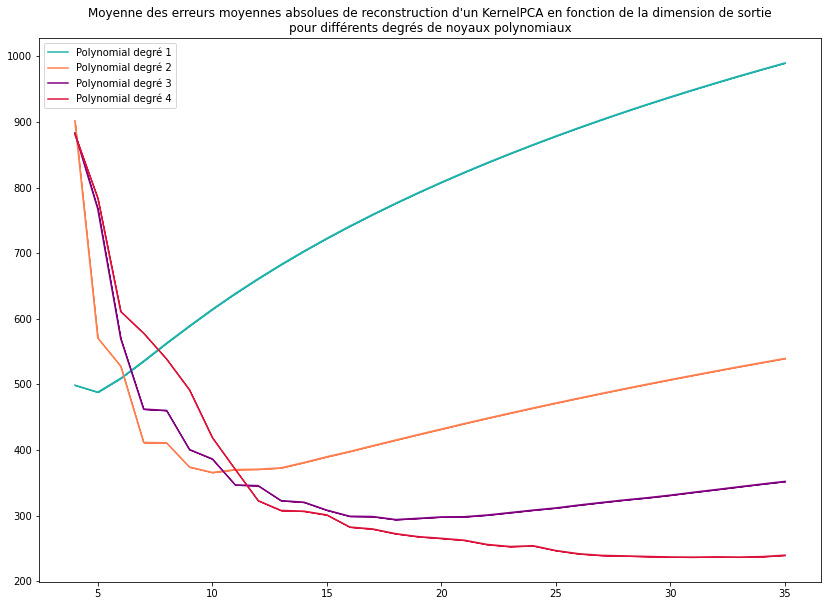

In [259]:
plt.figure(figsize=(14,10))
colors = ["lightseagreen", "coral", "purple", "crimson", "dodgerblue"]
for idd, d in enumerate(degrees):
    plt.plot(pca_dims, mae_kpca_per_degree[d], label='Polynomial degré '+str(d), color=colors[idd])
    ci = 1.96 * np.std([mae_kpca_poly_error[i][d] for i in range(cv)], axis=0)/np.sqrt(len(pca_dims))
    plt.fill_between(pca_dims, (mae_kpca_per_degree[d] - ci), (mae_kpca_per_degree[d] - ci), color=colors[idd])
plt.legend()
plt.title("Moyenne des erreurs moyennes absolues de reconstruction d'un KernelPCA en fonction de la dimension de sortie\npour différents degrés de noyaux polynomiaux")
plt.show()

Le modèle de KernelPCA offrant la meilleure erreur moyenne absolue de reconstruction pour une dimension de sortie supérieure à 12 est le KernelPCA à noyau polynomial de degré 4. C'est donc ce modèle que nous choisiront pour défendre le titre du meilleur embedding face aux autres modèles.

## Analyse finale

In [272]:
from sklearn.decomposition import * 
models = ['PCA', 'KernelPCA', 'FastICA',  'TruncatedSVD']
mae_error_models = {i: {model: [] for model in models} for i in range(cv)}

In [273]:
pca_dims = np.arange(4,48)
for i in range(cv):
    for dim in pca_dims:
        # Defining the models
        kpca = KernelPCA(n_components=dim, fit_inverse_transform=True, kernel='poly', degree=4)
        pca = PCA(n_components=dim)
        fastica = FastICA(n_components=dim)
        #lda = LatentDirichletAllocation(n_components=dim)
        svd = TruncatedSVD(n_components=dim)
        #factor_analysis = FactorAnalysis(n_components=dim)

        # Fitting
        kpca.fit(input_cvae)
        pca.fit(input_cvae)
        fastica.fit(input_cvae)
        #lda.fit(input_cvae)
        svd.fit(input_cvae)
        #factor_analysis.fit(input_cvae)

        # Transform
        z_kpca = kpca.transform(test_input_cvae)
        z_pca = pca.transform(test_input_cvae)
        z_fastica = fastica.transform(test_input_cvae)
        #z_lda = lda.transform(test_input_cvae)
        z_svd = svd.transform(test_input_cvae)
        #z_fa = factor_analysis.transform(test_input_cvae)

        # Inverse transform
        x_hat_kpca = kpca.inverse_transform(z_kpca)
        x_hat_pca = pca.inverse_transform(z_pca)
        x_hat_fastica = fastica.inverse_transform(z_fastica)
        #x_hat_lda = lda.inverse_transform(z_lda)
        x_hat_svd = svd.inverse_transform(z_svd)
        #x_hat_fa = factor_analysis.inverse_transform(z_fa)
        
        # Evaluate MAE on reconstruction
        mae_error_models[i]['KernelPCA'].append(np.mean(np.abs(conso_scaler.inverse_transform(x_hat_kpca).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019])))
        mae_error_models[i]['PCA'].append(np.mean(np.abs(conso_scaler.inverse_transform(x_hat_pca).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019])))
        mae_error_models[i]['FastICA'].append(np.mean(np.abs(conso_scaler.inverse_transform(x_hat_fastica).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019])))
        #mae_error_models[i]['LatentDirichletAllocation'].append(np.mean(np.abs(conso_scaler.inverse_transform(x_hat_lda).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019])))
        mae_error_models[i]['TruncatedSVD'].append(np.mean(np.abs(conso_scaler.inverse_transform(x_hat_svd).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019])))
        #mae_error_models[i]['FactorAnalysis'].append(np.mean(np.abs(conso_scaler.inverse_transform(x_hat_fa).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019])))

In [274]:
mae_per_model = {d: np.mean([mae_error_models[i][d] for i in range(cv)], axis=0) for d in models}

In [ ]:
plt.figure(figsize=(14,10))
colors = ["lightseagreen", "coral", "purple", "crimson", "dodgerblue"]
for idd, d in enumerate(models):
    plt.plot(pca_dims, mae_per_model[d], label=d, color=colors[idd])
    ci = 1.96 * np.std([mae_error_models[i][d] for i in range(cv)], axis=0)/np.sqrt(len(pca_dims))
    plt.fill_between(pca_dims, (mae_per_model[d] - ci), (mae_per_model[d] - ci), color=colors[idd])
plt.legend()
plt.title("Moyenne des erreurs moyennes absolues de reconstruction de plusieurs modèles en fonction de la dimension de sortie")
plt.show()

Les courbes d'erreur de la **PCA** et de la **FastICA** sont identiques et donc superposées ! Dans la pratique, l'algorithme ICA (**Independant Component Analysis**) est utilisé pour maximiser l'indépendance statistiques entre les signaux. 

In [299]:
pca_test = PCA(n_components=2) 
pca_test.fit(input_cvae)
z_test = pca_test.transform(test_input_cvae)

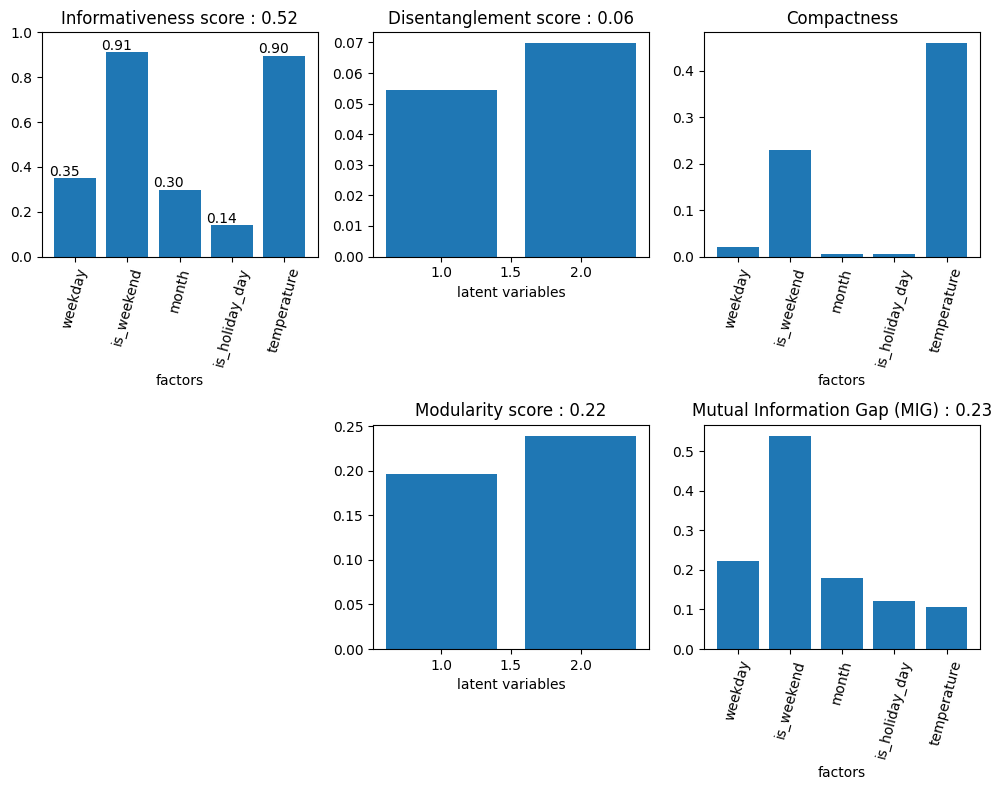

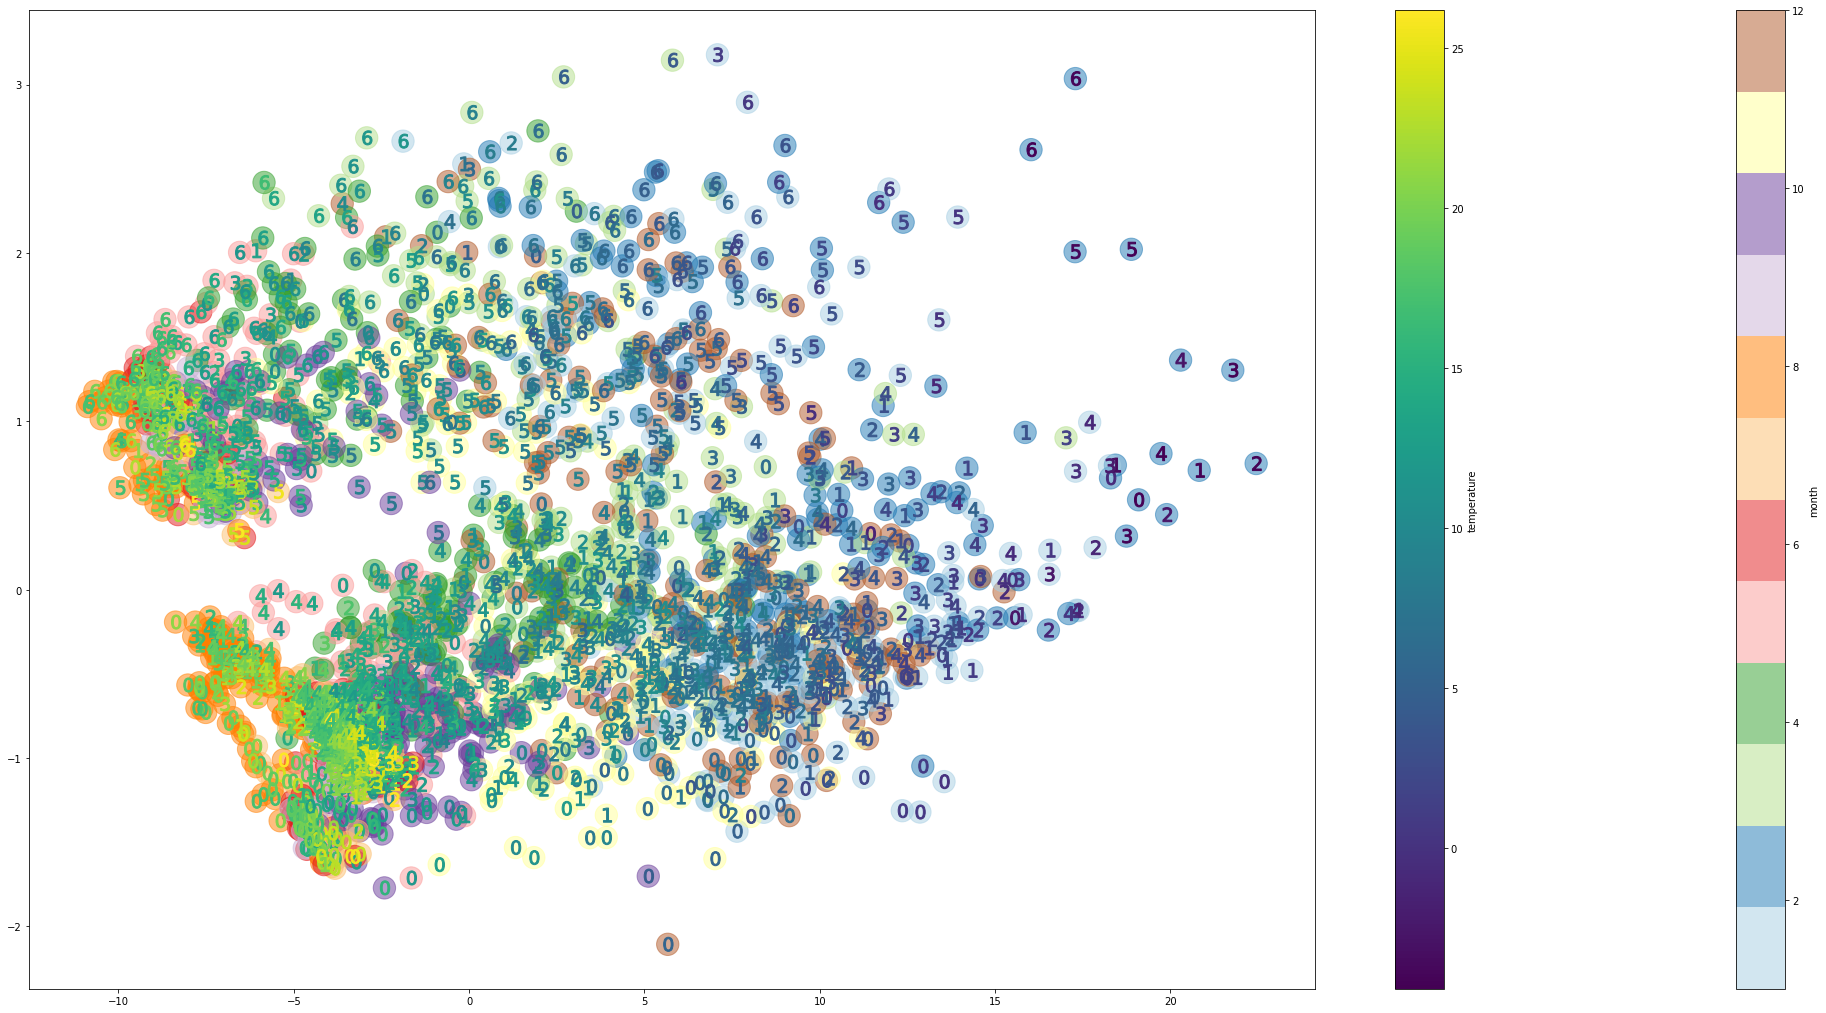

1016.5157728259834


In [301]:
z_train = pca_test.transform(input_cvae)
model_eval, importanceMatrix =evaluate_latent_code(z_train, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
display_evaluation_latent_code(model_eval, 2, factorDesc)
x_hat_test = pca_test.inverse_transform(z_test)
mae_kpca_cvae = np.mean(np.abs(conso_scaler.inverse_transform(x_hat_test).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019]))
prez_2D(z_train, factorMatrix[train_set,:], temperatureMean[train_set])
print(mae_kpca_cvae)

In [297]:
ica_test = FastICA(n_components=2) 
ica_test.fit(input_cvae)
z_ica_test = ica_test.transform(test_input_cvae)

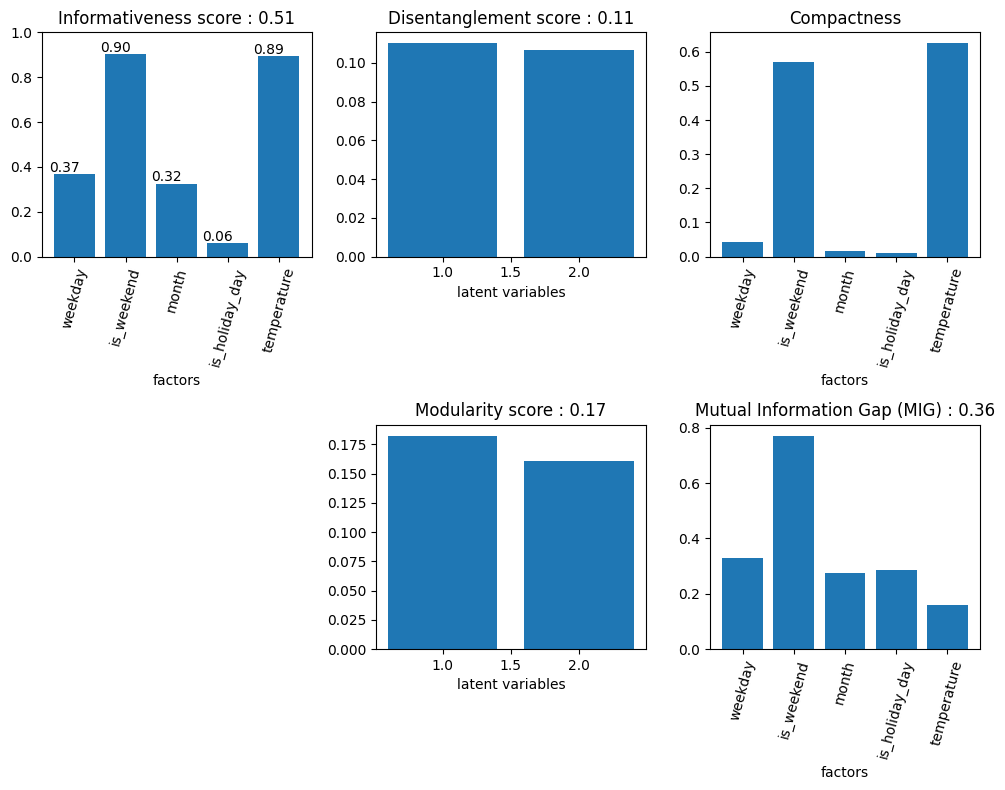

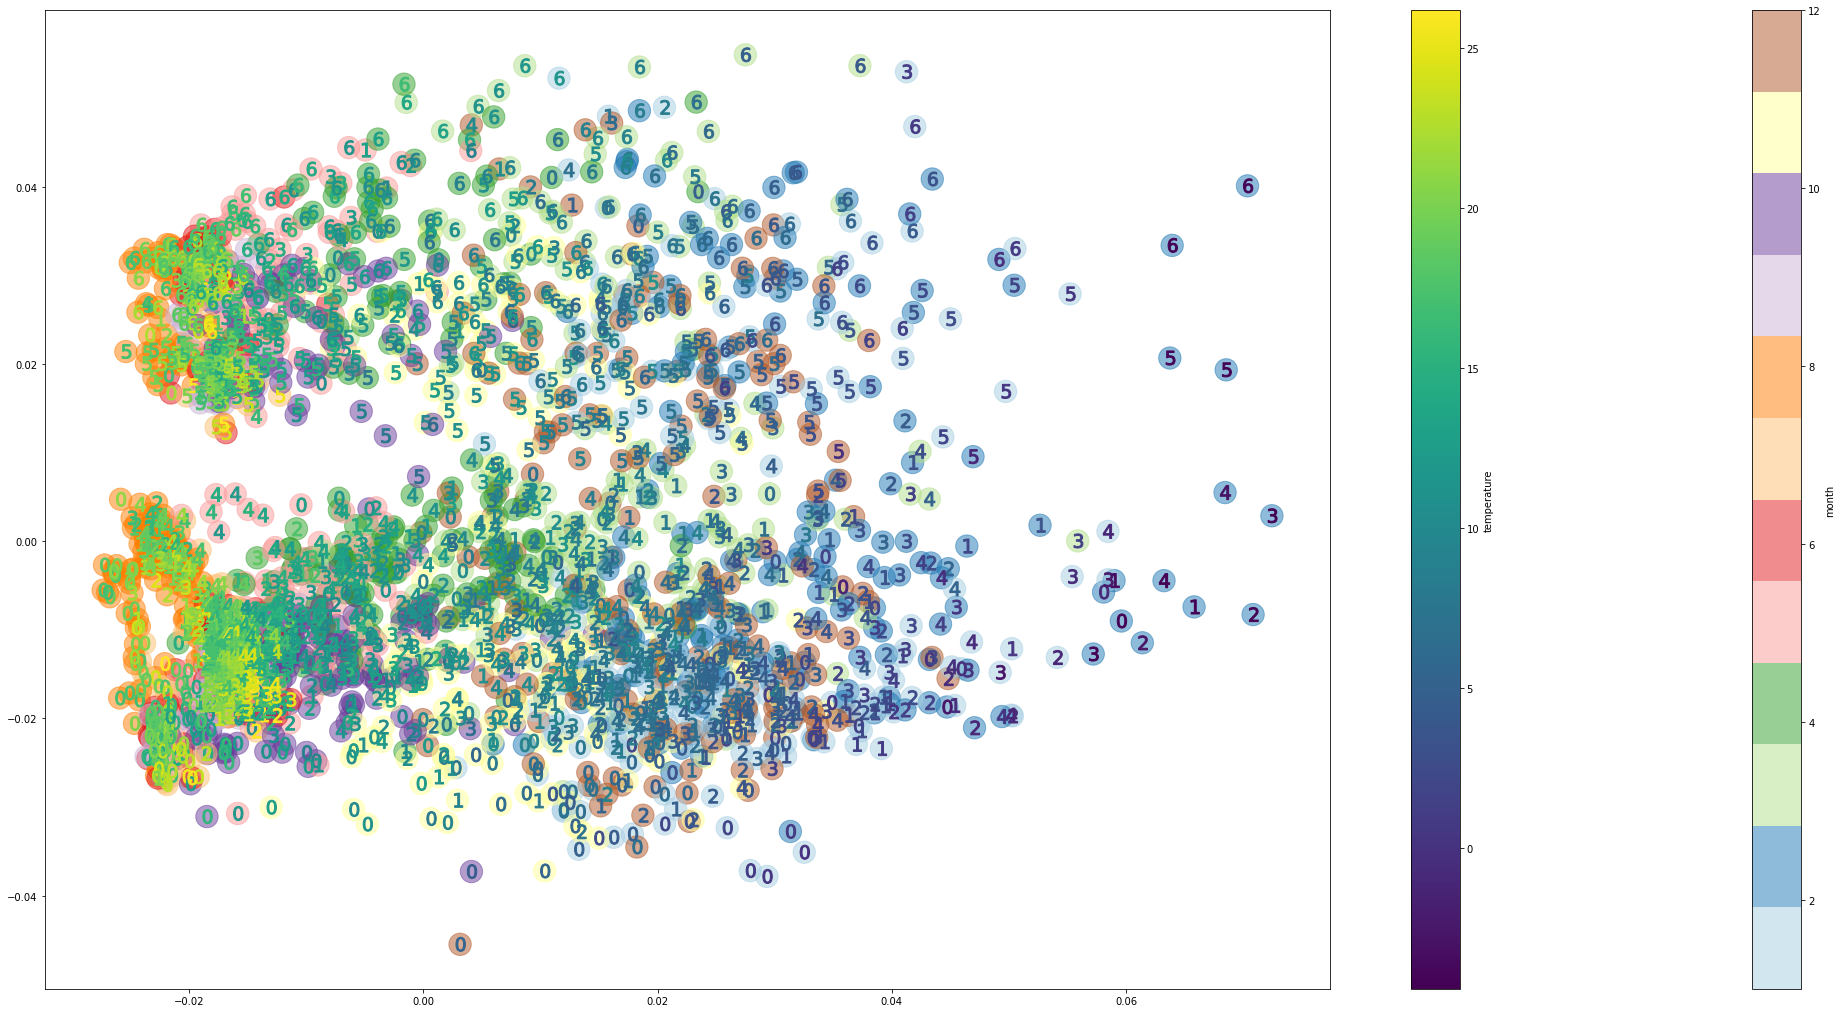

1016.5157728259817


In [298]:
z_ica_train = ica_test.transform(input_cvae)
model_eval, importanceMatrix =evaluate_latent_code(z_ica_train, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
display_evaluation_latent_code(model_eval, 2, factorDesc)
x_hat_ica_test = ica_test.inverse_transform(z_ica_test)
mae_kpca_cvae = np.mean(np.abs(conso_scaler.inverse_transform(x_hat_ica_test).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019]))
prez_2D(z_ica_train, factorMatrix[train_set,:], temperatureMean[train_set])
print(mae_kpca_cvae)

In [309]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[12,24,35,70,48]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = 48

In [310]:
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.input_dims = input_dim
vae_params.model_params.output_dims = input_dim
vae_params.model_params.cond_dims = []
vae_params.model_params.with_embedding = False
vae_params.model_params.with_Time2Vec = False
vae_params.model_params.emb_dims = [[48,8],[12,8],6]
vae_params.model_params.nb_encoder_ensemble = 1

In [311]:
#example of custom loss definition

loss_weights = {"recon_loss" : 1,
                "kl_loss" : 0.33,
                "info_loss" : 75}

vae_loss = VAELoss(loss_weights = loss_weights) #change None to custom_loss if will to use one
vae_loss.options["log_prior_sigma"] = [-2.,-1.,0.,1]

vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = lr


Model: "cvae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_inputs (InputLayer)          [(None, 48)]         0           []                               
                                                                                                  
 encoder (Functional)           [(None, 4),          5335        ['x_inputs[0][0]']               
                                 (None, 4)]                                                       
                                                                                                  
 reparametrizing_layer (Lambda)  (None, 4)           0           ['encoder[0][0]',                
                                                                  'encoder[0][1]']                
                                                                                               

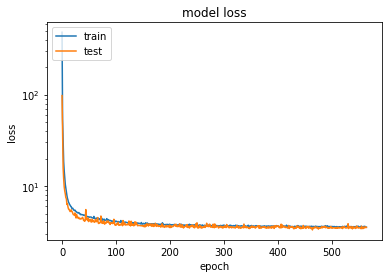

## MODEL SAVED ##


In [312]:
cvae_fft = CVAE(vae_params)
cvae_fft.build_model(vae_params)

from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
cvae_fft.train(y, y, epochs= 2000, verbose=1,
            batch_size=batch_size, callbacks=[earl_stop]) 


In [316]:
z = cvae_fft.encoder.predict(y)[0]
model_eval, _ = evaluate_latent_code(z, factorMatrix[train_set,:], factorDesc)

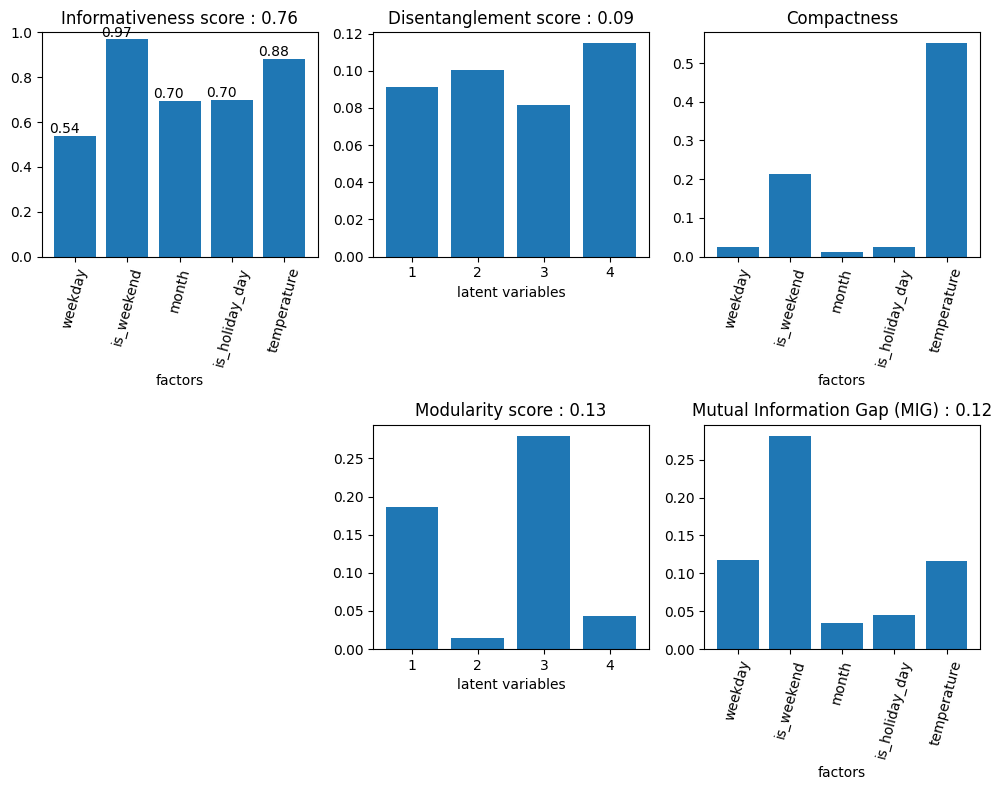

In [317]:
display_evaluation_latent_code(model_eval, z_dim, factorDesc)

In [320]:
z

array([[-0.00258434, -1.7134762 ,  1.3581433 ,  0.6414126 ],
       [-0.48783362,  0.1214298 ,  0.27779225, -0.6944308 ],
       [-0.06682086,  0.69912916,  0.21194676, -1.7117388 ],
       ...,
       [ 0.13800317, -0.6011588 ,  0.39863005, -1.3618697 ],
       [ 0.01731449, -0.8694431 ,  0.60403323, -0.834888  ],
       [ 0.32247782, -0.20638695,  0.52691734, -0.9308522 ]],
      dtype=float32)

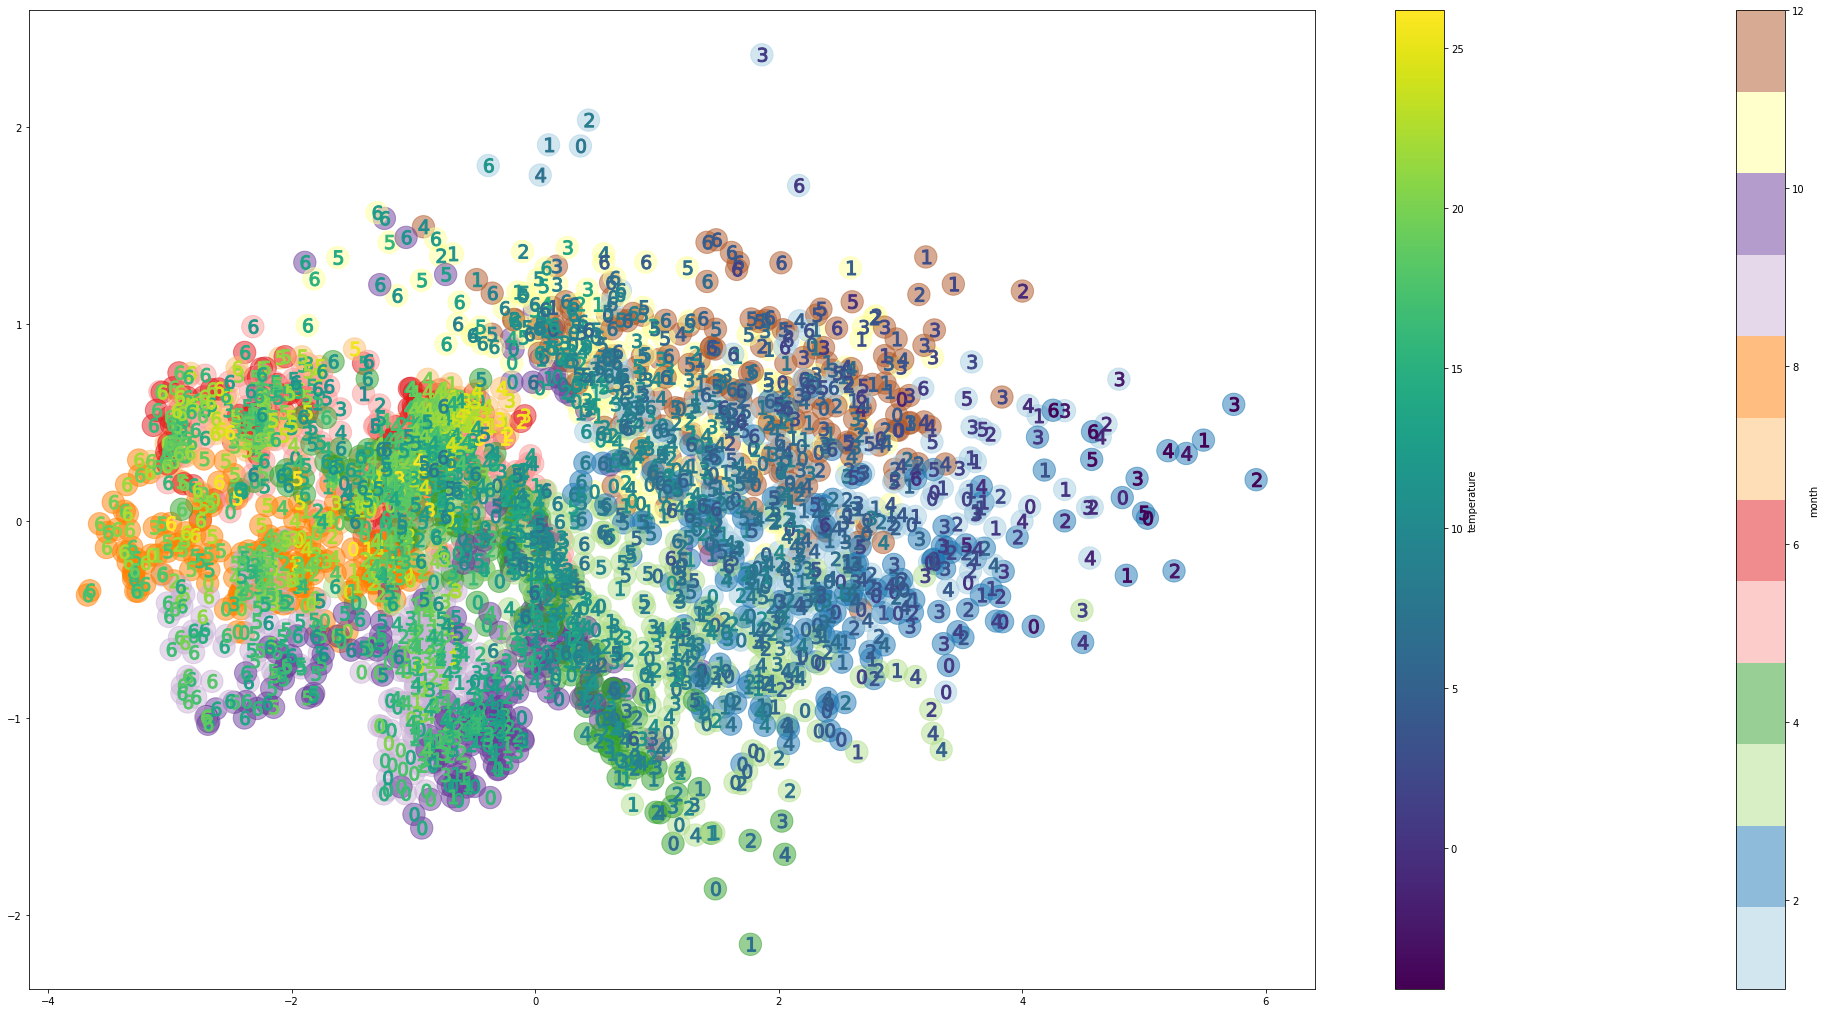

In [319]:
prez_2D(z, factorMatrix[train_set,:], temperatureMean[train_set])

## Apprentissage de CVAE sur des embeddings des données via les modèles étudiés

In [330]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[16,12,8,6]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[6,8,12,16]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = 16
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.input_dims = input_dim
vae_params.model_params.output_dims = input_dim
vae_params.model_params.cond_dims = []
vae_params.model_params.with_embedding = False
vae_params.model_params.with_Time2Vec = False
vae_params.model_params.emb_dims = [[48,8],[12,8],6]
vae_params.model_params.nb_encoder_ensemble = 1

In [331]:
#example of custom loss definition

loss_weights = {"recon_loss" : 1,
                "kl_loss" : 0.33,
                "info_loss" : 66}

vae_loss = VAELoss(loss_weights = loss_weights) #change None to custom_loss if will to use one
vae_loss.options["log_prior_sigma"] = [-2.,-1.,0.,1]

vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = lr


In [332]:
models = ['PCA', 'KernelPCA', 'FastICA',  'TruncatedSVD']
cv = 5
cvae_models = {i: {model: [] for model in models} for i in range(cv)}
error_cvae = {i: {model: {'RMSE': 0, 'MAE': 0, 'MAPE': 0} for model in models} for i in range(cv)}

In [ ]:
for i in range(cv):
    embedding_models = {'PCA': PCA(n_components=input_dim),
                        'KernelPCA': KernelPCA(n_components=input_dim, fit_inverse_transform=True, kernel='poly', degree=4),
                        'FastICA': FastICA(n_components=input_dim),
                        'TruncatedSVD': TruncatedSVD(n_components=input_dim)}

    for id_model, model in enumerate(embedding_models):
        print(f"Apprentissage CVAE n°{i+1}/{cv} pour un embedding en dimension 16 avec l'algorithme {model}")
        
        emb_model = embedding_models[model]
        input_emb = emb_model.fit_transform(input_cvae)
        cvae_models[i][model] = CVAE(vae_params)
        cvae_models[i][model].build_model(vae_params)

        from tensorflow.keras.callbacks import EarlyStopping
        earl_stop = EarlyStopping(
            monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
            baseline=None, restore_best_weights=True
        )
        cvae_models[i][model].train(input_emb, input_emb, epochs= 2000, verbose=1,
                    batch_size=batch_size, callbacks=[earl_stop]) 
        
        # Model's evaluation
        # Graphics and metrics
        z_emb = cvae_models[i][model].encoder.predict(input_emb)[0]
        model_eval, _ =evaluate_latent_code(z_emb, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
        display_evaluation_latent_code(model_eval, z_dim, factorDesc)
        prez_2D(z_emb, factorMatrix[train_set,:], temperatureMean[train_set])

        # Evaluation on RMSE, MAE and MAPE criteria
        test_input_emb = emb_model.transform(test_input_cvae)
        x_hat_emb = cvae_models[i][model].model.predict(test_input_emb)
        x_hat = emb_model.inverse_transform(x_hat_emb)
        error_cvae[i][model]['MAE'] = np.mean(np.abs(conso_scaler.inverse_transform(x_hat).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019]))
        error_cvae[i][model]['MAPE'] = 100*np.mean(np.abs((conso_scaler.inverse_transform(x_hat).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019])/df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019]))
        error_cvae[i][model]['RMSE'] = np.sqrt(np.mean(np.square(conso_scaler.inverse_transform(x_hat).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019])))

### Analyse des résultats obtenus

In [345]:
final_errors = {model: {metric: {'mean': 0, 'std': 0.} for metric in ['RMSE','MAE','MAPE']} for model in models}

In [346]:
for model in models:
    for metric in ['RMSE','MAE','MAPE']:
        final_errors[model][metric]['mean'] = np.mean([error_cvae[i][model][metric] for i in range(cv)])
        final_errors[model][metric]['std'] = np.std([error_cvae[i][model][metric] for i in range(cv)])

In [348]:
final_errors

{'PCA': {'RMSE': {'mean': 1325.9802556927723, 'std': 80.53596803505158},
  'MAE': {'mean': 1020.1390512167396, 'std': 48.575914653363476},
  'MAPE': {'mean': 1.9483223184669238, 'std': 0.08236005742832492}},
 'KernelPCA': {'RMSE': {'mean': 2081.489345779205, 'std': 109.8155510883229},
  'MAE': {'mean': 1489.9948857259071, 'std': 59.45564900783952},
  'MAPE': {'mean': 2.8057701982802197, 'std': 0.10075097068800153}},
 'FastICA': {'RMSE': {'mean': 11259.527410154857, 'std': 581.3683545500194},
  'MAE': {'mean': 9325.074262165654, 'std': 400.0334426913659},
  'MAPE': {'mean': 17.862749798811638, 'std': 1.104271317263085}},
 'TruncatedSVD': {'RMSE': {'mean': 1282.0207142401187,
   'std': 76.6457496796846},
  'MAE': {'mean': 988.1627980441906, 'std': 47.04681906629784},
  'MAPE': {'mean': 1.8931150078645884, 'std': 0.08876307027400489}}}

Le modèle donnant la meilleure erreur de reconstruction est le CVAE ayant été appris sur un embedding TruncatedSVD. La perte de reconstruction (MAE) est réduite d'environ 18% par rapport à un CVAE classique (voir ci-dessous).

### Comparaison avec un CVAE classique 

Default values for model architecture are:
with_embedding  :=  False
with_Time2Vec  :=  True
emb_dims  :=  []
kernel_initializer  :=  glorot_uniform
bias_initializer  :=  glorot_uniform
reparametrize  :=  GaussianSampling
intel_function  :=  scalar_binary
input_dims  :=  48
output_dims  :=  48
t2v_dims  :=  12
latent_dims  :=  4
nb_latent_components  :=  2
nb_encoder_ensemble  :=  1
encoder_dims  :=  [12, 10, 8, 6]
encoder_type  :=  NNBlockCond_model
nb_decoder_outputs  :=  1
nb_decoder_ensemble  :=  1
decoder_dims  :=  [6, 12, 24, 48]
latent_encoder_dims  :=  [4, 3, 3, 4]
latent_mask  :=  0
decoder_type  :=  InceptionBlock_model
embedding_type  :=  EmbeddingBlock_model
cond_dims  :=  []
cond_insert  :=  {'encoder': [], 'decoder': []}
context_dims  :=  None
leapae_dims  :=  [4, None]
Default parameters for training are a L2 loss with Adam optimizer with a learning rate of 0.0003
Model: "cvae"
______________________________________________________________________________________________

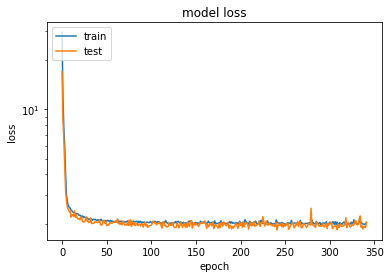

## MODEL SAVED ##


In [116]:
# paramètres de l'autoencodeur
z_dim = 4 # le nombre de dimensions voulues dans notre représentation latente
e_dims=[48,35,24,12]# les couches cachées du bloc encodeur; premier nombre = inputs_dim
d_dims=[12,24,35,48]# les couches cachées du bloc decodeur; premier nombre = outputs_dim
lr=3e-4 # le learning rate de l'optimiseur
input_dim = df_conso.shape[1]
# paramètres de l'entrainement du modèle
epochs = 800
batch_size = 16
vae_params = VAE_params(name=name_model, out_dir = log_dir_model)
vae_params.set_model_params()
vae_params.set_training_params()
vae_params.model_params.encoder_dims = e_dims
vae_params.model_params.decoder_dims = d_dims
vae_params.model_params.input_dims = input_dim
vae_params.model_params.output_dims = input_dim
vae_params.model_params.cond_dims = []
vae_params.model_params.with_embedding = False
vae_params.model_params.with_Time2Vec = False
vae_params.model_params.emb_dims = [[48,8],[12,8],6]
vae_params.model_params.nb_encoder_ensemble = 1
#example of custom loss definition
def loss_1(y_true, y_pred, latent_mu ,eps=2):
    return tf.math.reduce_sum(K.abs(K.sqrt(K.sum(K.square(latent_mu),axis=-1)) - eps))

loss_weights = {"recon_loss" : 1,
                "kl_loss" : 0.3,
                "info_loss" : 75}

vae_loss = VAELoss(loss_weights = loss_weights) #change None to custom_loss if will to use one
vae_loss.options["log_prior_sigma"] = [-2.,-1.,0.,1]

vae_params.training_params.loss = vae_loss
vae_params.training_params.lr = lr

cvae = CVAE(vae_params)
cvae.build_model(vae_params)

from tensorflow.keras.callbacks import EarlyStopping
earl_stop = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)

cvae.train(input_cvae, output_cvae, epochs= 1000, verbose=1,
        batch_size=batch_size, callbacks=[earl_stop])



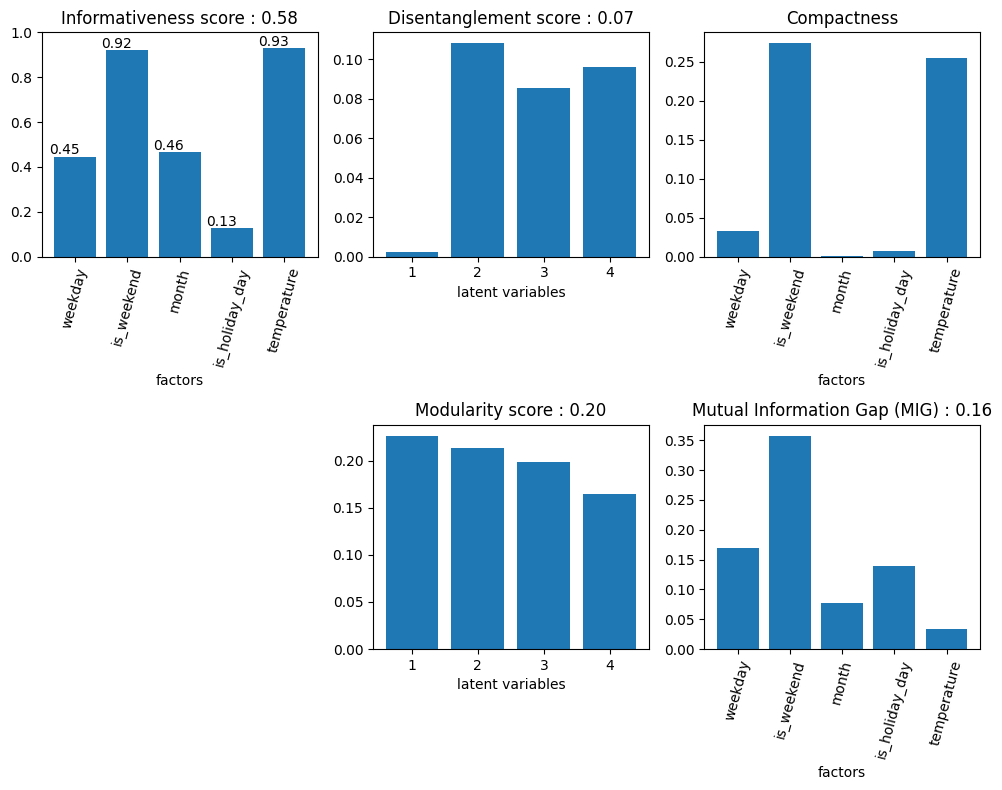

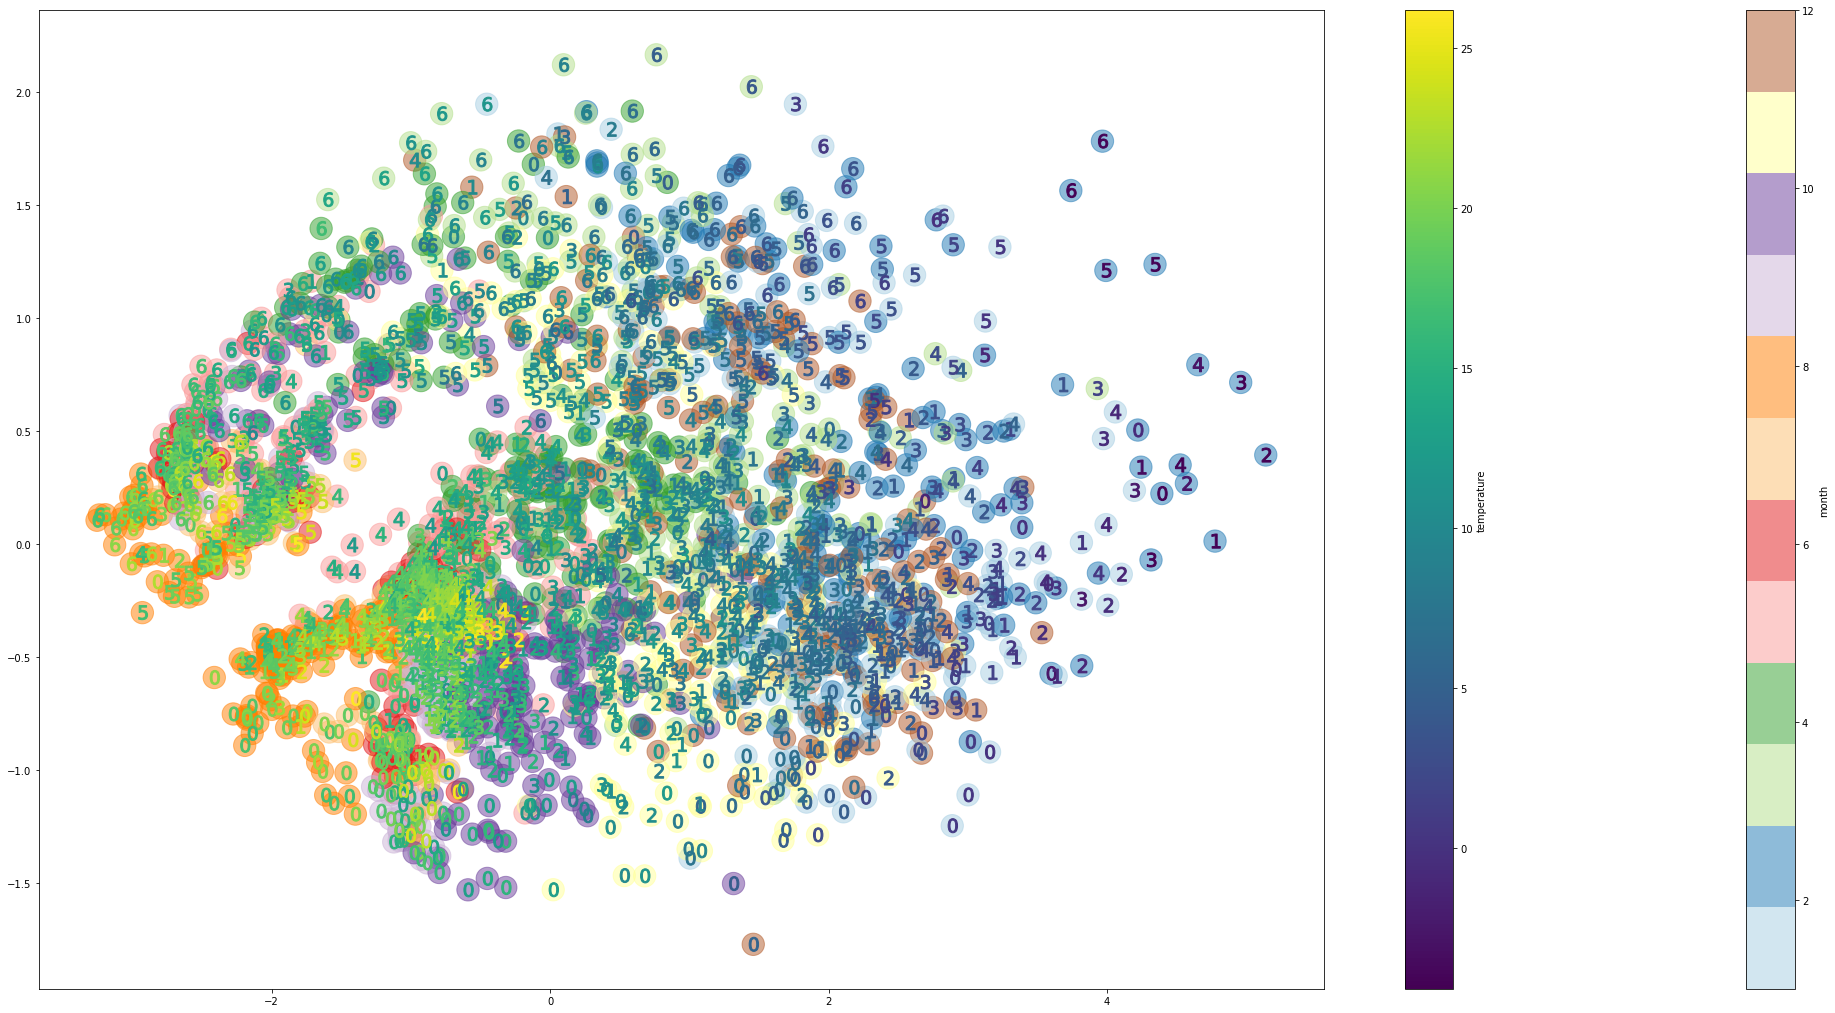

In [117]:
x_encoded = cvae.encoder.predict(input_cvae)[0]
model_eval, importanceMatrix =evaluate_latent_code(x_encoded, factorMatrix[train_set,:], factorDesc, orthogonalize=True, normalize_information=True)
display_evaluation_latent_code(model_eval, z_dim, factorDesc)
x_hat_cvae = cvae.model.predict(test_input_cvae)
mae_cvae = np.mean(np.abs(conso_scaler.inverse_transform(x_hat_cvae).ravel() - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019]))
prez_2D(x_encoded_pca, factorMatrix[train_set,:], temperatureMean[train_set])

In [118]:
mae_cvae

1210.328738918914

In [119]:
cvae_hourerror = np.mean(np.abs(conso_scaler.inverse_transform(x_hat_cvae) - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019].reshape(365,48)),axis=0)
cvae_dayerror = np.mean(np.abs(conso_scaler.inverse_transform(x_hat_cvae) - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019].reshape(365,48)),axis=1)
kpca_hourerror = np.mean(np.abs(conso_scaler.inverse_transform(x_hat) - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019].reshape(365,48)),axis=0)
kpca_dayerror = np.mean(np.abs(conso_scaler.inverse_transform(x_hat) - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019].reshape(365,48)),axis=1)
pca_hourerror = np.mean(np.abs(conso_scaler.inverse_transform(x_hat_pca) - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019].reshape(365,48)),axis=0)
pca_dayerror = np.mean(np.abs(conso_scaler.inverse_transform(x_hat_pca) - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019].reshape(365,48)),axis=1)

In [124]:
pca_comparaison = PCA(n_components=z_dim)
pca_comparaison.fit(input_cvae)
comparaison = pca_comparaison.inverse_transform(pca_comparaison.transform(test_input_cvae))
comparaison_hourerror = np.mean(np.abs(conso_scaler.inverse_transform(comparaison) - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019].reshape(365,48)),axis=0)
comparaison_dayerror = np.mean(np.abs(conso_scaler.inverse_transform(comparaison) - df_data.Consommation.values[df_data.utc_datetime.dt.year == 2019].reshape(365,48)),axis=1)

In [120]:
index = pd.DataFrame(pd.date_range("00:00", "23:30", freq="30min")).apply(lambda x:str(x)[15:20], axis=1)
index = index.values
index[0]= '00:00'

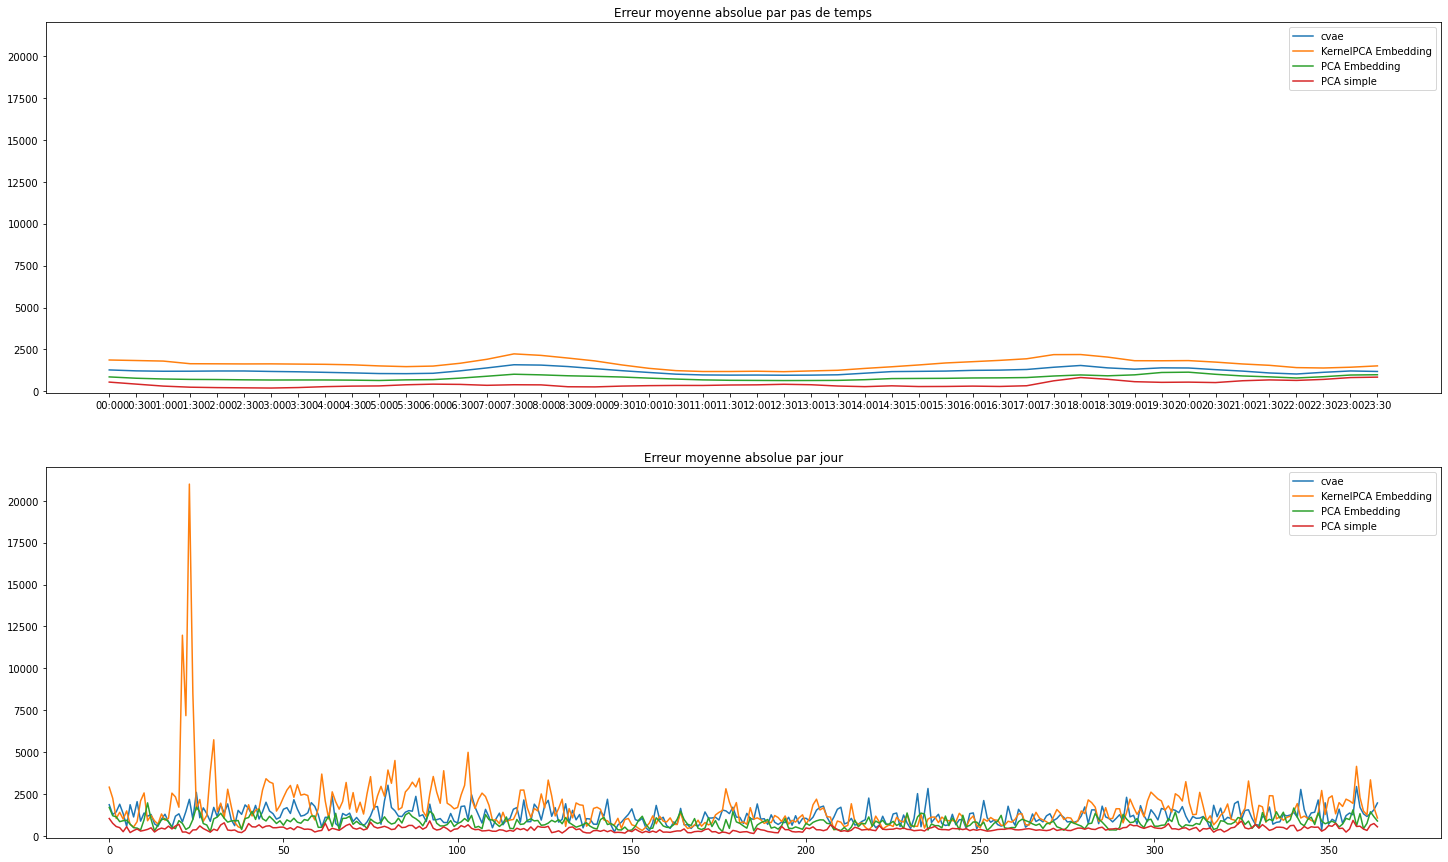

In [133]:
fig, axs = plt.subplots(2,1,figsize=(25,15))

axs[0].plot(index,cvae_hourerror, label='cvae')
axs[0].plot(index,kpca_hourerror, label='KernelPCA Embedding')
axs[0].plot(index,pca_hourerror, label='PCA Embedding')
axs[0].plot(index,comparaison_hourerror, label='PCA simple')
axs[0].legend()
axs[0].set(ylim=(-100,22000))
axs[0].set_title('Erreur moyenne absolue par pas de temps')


axs[1].plot(cvae_dayerror, label='cvae')
axs[1].plot(kpca_dayerror, label='KernelPCA Embedding')
axs[1].plot(pca_dayerror, label='PCA Embedding')
axs[1].plot(comparaison_dayerror, label='PCA simple')
axs[1].legend()
axs[1].set(ylim=(-100,22000))
axs[1].set_title('Erreur moyenne absolue par jour')
plt.show()

df = pd.DataFrame(data={'day':pd.date_range(start='1/1/2019', end='31/12/2019'),
                        'CVAE': cvae_dayerror,
                        'KernelPCA emb':kpca_dayerror,
                        'PCA emb': pca_dayerror,
                        'PCA': comparaison_dayerror,
                        'holiday': df_calendar[df_calendar.year == 2019]['is_holiday_day']})
df['month']=df.day.apply(lambda x: x.month)

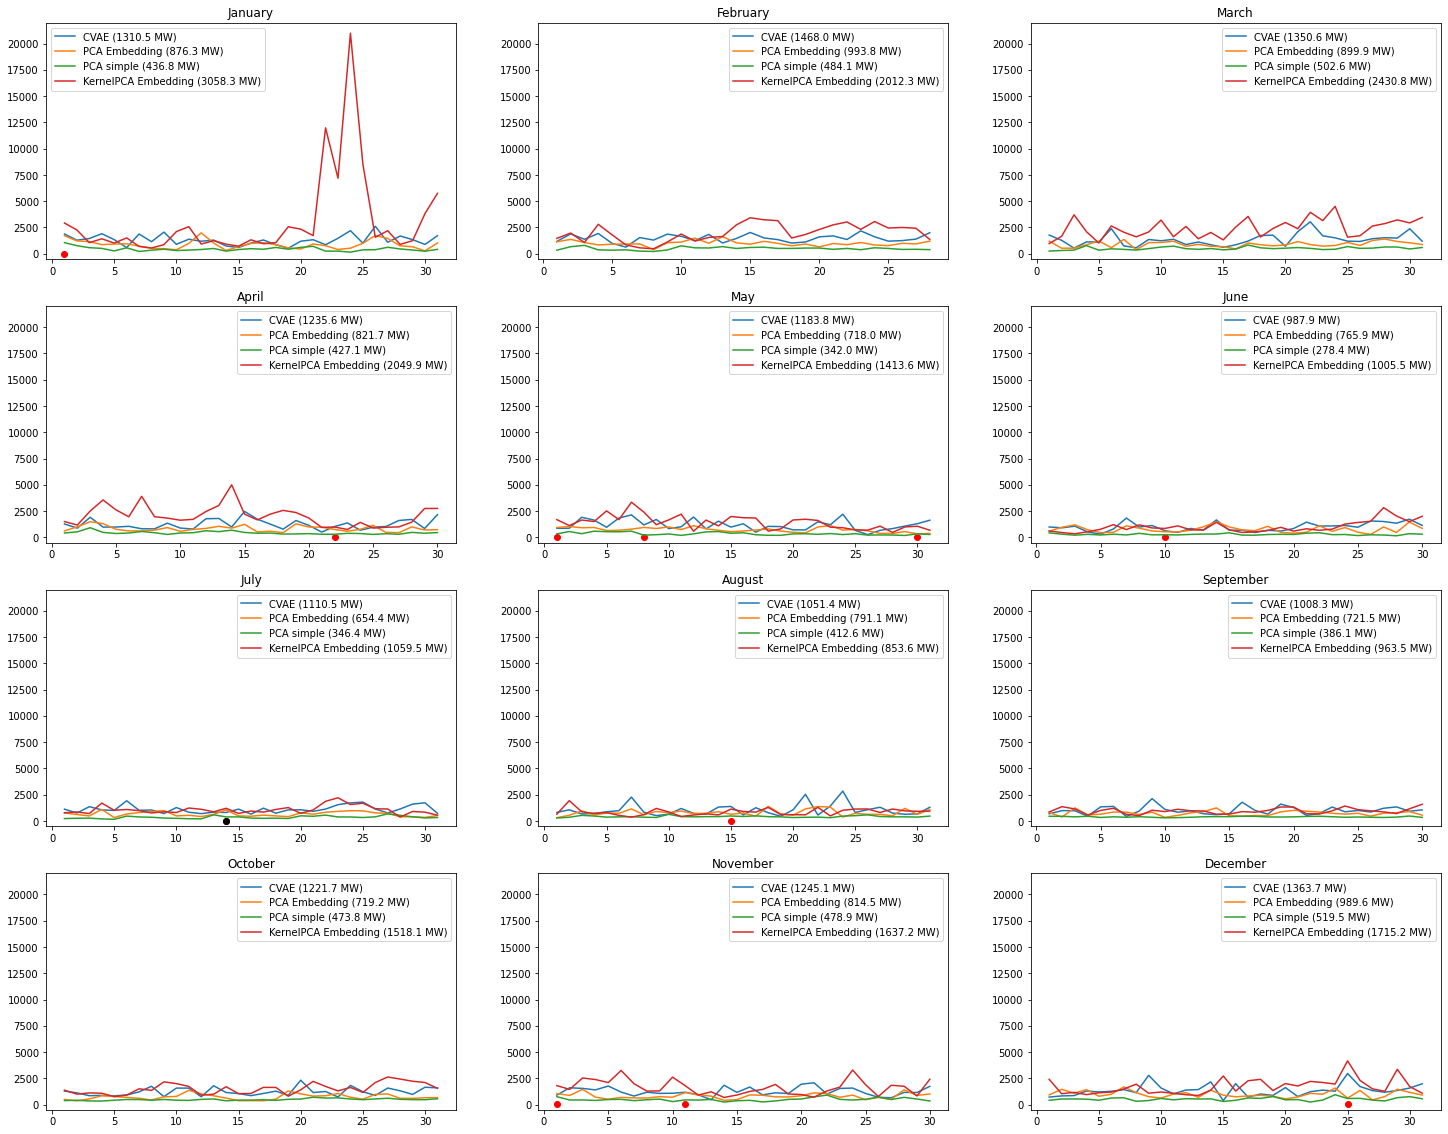

In [130]:
months = ['January', 'February', 'March','April', 'May', 'June', 'July', 'August','September','October','November', 'December']
fig, axs = plt.subplots(4,3,figsize=(25,20))
for i in range(4):
    for j in range(3):
        holiday = df[df.month == 3*i+j+1]['holiday']
        holiday_mask = np.ma.masked_where(holiday < [1.]*holiday.shape[0], 10*holiday)
        holiday_weekend = holiday * df_calendar[(df_calendar.month == 3*i+j+1) & (df_calendar.year==2019)]['is_weekend'].astype(float).values
        holiday_weekend_mask = np.ma.masked_where(holiday_weekend < [1.]*holiday_weekend.shape[0], 10*holiday_weekend)
        axs[i][j].plot(np.arange(1,df[df.month == 3*i+j+1]['CVAE'].shape[0]+1),df[df.month == 3*i+j+1]['CVAE'], label=f"CVAE ({round(df[df.month == 3*i+j+1]['CVAE'].mean(),1)} MW)")
        axs[i][j].plot(np.arange(1,df[df.month == 3*i+j+1]['PCA emb'].shape[0]+1),df[df.month == 3*i+j+1]['PCA emb'], label=f"PCA Embedding ({round(df[df.month == 3*i+j+1]['PCA emb'].mean(),1)} MW)")
        axs[i][j].plot(np.arange(1,df[df.month == 3*i+j+1]['PCA'].shape[0]+1),df[df.month == 3*i+j+1]['PCA'], label=f"PCA simple ({round(df[df.month == 3*i+j+1]['PCA'].mean(),1)} MW)")
        axs[i][j].plot(np.arange(1,df[df.month == 3*i+j+1]['KernelPCA emb'].shape[0]+1),df[df.month == 3*i+j+1]['KernelPCA emb'], label=f"KernelPCA Embedding ({round(df[df.month == 3*i+j+1]['KernelPCA emb'].mean(),1)} MW)")
        axs[i][j].scatter(np.arange(1,df_calendar[(df_calendar.month == 3*i+j+1) & (df_calendar.year==2019)]['is_holiday_day'].shape[0]+1),holiday_mask, color='red')
        axs[i][j].scatter(np.arange(1,df_calendar[(df_calendar.month == 3*i+j+1) & (df_calendar.year==2019)]['is_holiday_day'].shape[0]+1),holiday_weekend_mask, color='black')
        axs[i][j].legend()
        axs[i][j].set(ylim =(-500, 22000))
        axs[i][j].set_title(months[3*i+j])